# 0 - Library imports

In [ ]:
# Builtins
import os
import sys
from pathlib import Path
# Installed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
# Types
from typing import Any

In [2]:
# Set path for custom imports
project_root = os.path.abspath('..')
print(project_root)
sys.path.append(project_root)

/home/promise/jhernandez/3d-notebooks/3d/9jun25/9jun25


In [ ]:
# Local
from src.dataloader import TorchDataLoader
from src.unet import (
    UNet3D,
    AttentionUnet3D
)
from src.vit import VisionTransformer
from src.utils.config_files import load_config
from src.evaluator import ModelEvaluator
from src.utils.torchloader import (
    load_complete_model,
    load_model_with_params,
    load_torch_model_state_dict
)

In [4]:
print(
    f"PyTorch detects {torch.cuda.device_count()} GPU(s): {', '.join(torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count()))}" 
    if torch.cuda.is_available() 
    else "PyTorch can't find any GPU"
)

PyTorch detects 1 GPU(s): NVIDIA A100-SXM4-80GB


# 1 - Global

## 1.1 - Vars

In [5]:
BOLD = "\033[1m"      # Bold
ITALIC = "\033[3m"    # Italic
RESET = "\033[0m"     # Reset stdout modifications

DATA_DIR_PATH = Path('/home/promise/NAS/MATERIA_OSCURA/PROYECTOS_INVESTIGACION/2025-Direct_AC/001-Dataset/002-PET_NAC_AC/')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.2 - Functions

In [ ]:
def display_configurations(model_config: dict[str, Any], data_config: dict[str, Any]) -> None:
    """Show data and model configurations"""
    print(f"{BOLD} - Data Directory Path:{RESET:>5} {ITALIC}{DATA_DIR_PATH}{RESET}")
    print(f"{BOLD} - Using device:{RESET:>11} {ITALIC} {DEVICE}{RESET}")
    
    print("\n=== Data Configuration ===")
    max_data_key_len = max(len(key) for key in data_config.keys())
    for key, value in data_config.items():
        print(f"{BOLD} - {key + ':':<{max_data_key_len + 2}}{RESET} {ITALIC}{value}{RESET}")
    
    print("\n=== Model Configuration ===")
    max_model_key_len = max(len(key) for key in model_config.keys())
    for key, value in model_config.items():
        print(f"{BOLD} - {key + ':':<{max_model_key_len + 2}}{RESET} {ITALIC}{value}{RESET}")

In [ ]:
def get_global_metrics(
    model_config: dict[str, Any],
    evaluator: ModelEvaluator,
    test_loader: DataLoader,
    plot_hist: bool=False
) -> UNet3D | AttentionUnet3D | VisionTransformer:
    """Display the model training evolution plot (if 'plot_hist' = True) and the metrics obtained using the test set"""
    if plot_hist:
        evaluator.plot_model_training_evolution()

    model_save_path = os.path.join('..', 'models', model_config['name'], 'models', f'{model_config["name"]}.pt')

    init_params = {
        "model_config": model_config
    }

    if model_config['save_method'] == 'state_dict':
        if model_config['model_type'] == 'unet-original':
            model_architecture = UNet3D(**init_params)
        elif model_config['model_type'] == 'unet-attention':
            model_architecture = AttentionUnet3D(**init_params)
        elif model_config['model_type'] == 'vit':
            model_architecture = VisionTransformer(**init_params)
        model = load_torch_model_state_dict(model_save_path, model_architecture=model_architecture, device=DEVICE)
    elif model_config['save_method'] == 'complete':
        model = load_complete_model(model_save_path)
    else:
        model, model_info = load_model_with_params(model_save_path.replace('.pth', '.pt'), model_config=model_config, device=DEVICE)

    # Evaluate the model
    metrics = evaluator.evaluate_prediction_quality(model, test_loader, DEVICE)
    print(f"== Evaluation metrics ==")
    for k, v in metrics.items():
        print(f" - {k}: {round(v, 4)}")

    return model

# 2 - Test original Unet

In [ ]:
model_name = 'Unet1'

data_config = load_config(os.path.join('..', 'models', model_name, 'config', 'data_config.json'))
model_config = load_config(os.path.join('..', 'models', model_name, 'config', 'model_config.json'))

# Take less images (focus on the brain slices)
data_config['first_cut'] = 65
data_config['last_cut'] = 100

dataloader = TorchDataLoader(
        data_dir_path=DATA_DIR_PATH,
        data_config=data_config,
        model_config=model_config
)
test_loader = dataloader.load_test_data()

evaluator = ModelEvaluator(model_config=model_config)

model = get_global_metrics(model_config, evaluator, test_loader)

Configuration from '../models/Unet1/config/data_config.json' loaded successfully.
Configuration from '../models/Unet1/config/model_config.json' loaded successfully.
Configuration saved to: '/home/promise/jhernandez/3d-notebooks/3d/9jun25/9jun25/models/Unet1/config/data_config.json'...
Configuration saved to: '/home/promise/jhernandez/3d-notebooks/3d/9jun25/9jun25/models/Unet1/config/model_config.json'...
Loading test data...
 ==  Loading test images set  ==
	- Loading 8 images from '/home/promise/NAS/MATERIA_OSCURA/PROYECTOS_INVESTIGACION/2025-Direct_AC/001-Dataset/002-PET_NAC_AC/fold1' ...
	- Could only load 6 images. Detected 2 outlier(s)
	- Pixels value range: [0.0, 0.23]
Using first half of test set for testing...
Test inputs shape: (12, 1, 8, 128, 128)
Test targets shape: (12, 1, 8, 128, 128)
Test loader generated. Batch size: 8
== Test set loader ==
Batch 2 size 4 != expected size 8
Common batch shape (num_batches / batch_size, channels, depth / num_layers, height, width):
 - Inp

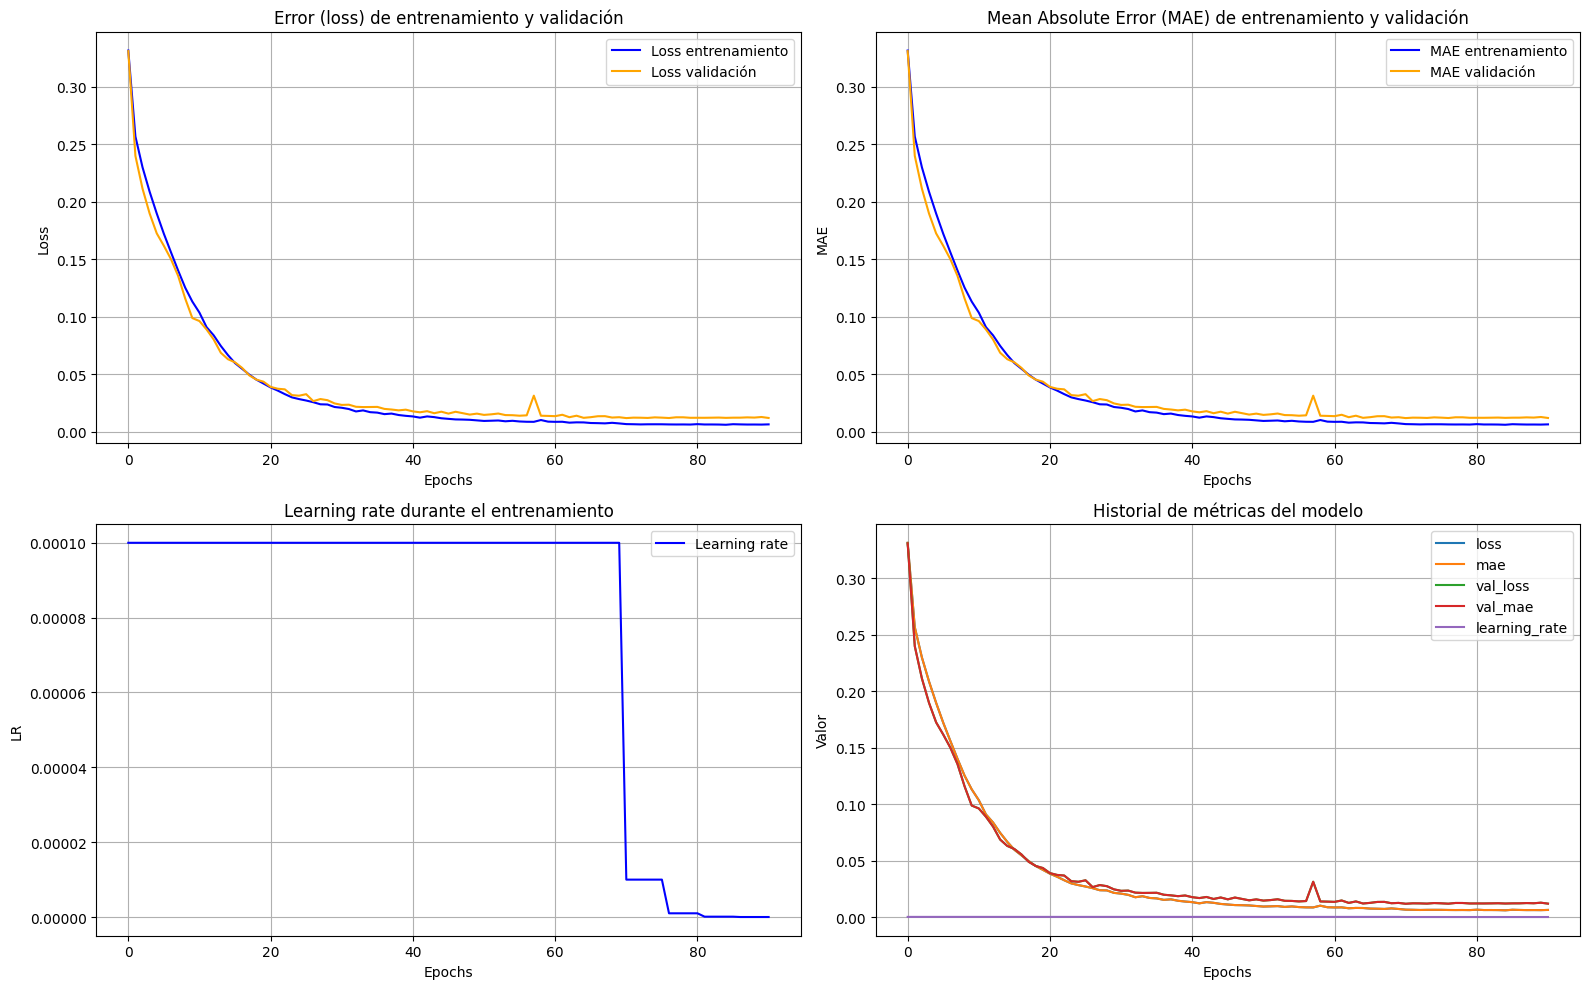

In [12]:
evaluator.plot_model_training_evolution()

torch.Size([8, 1, 8, 128, 128])
Input shape: torch.Size([8, 1, 8, 128, 128])
Target shape: torch.Size([8, 1, 8, 128, 128])
Prediction shape: torch.Size([8, 1, 8, 128, 128])
------------------------------------------------------------------------------------------------------------------------
-35.97398
------------------------------------------------------------------------------------------------------------------------
-48.403397
------------------------------------------------------------------------------------------------------------------------
-136.32037


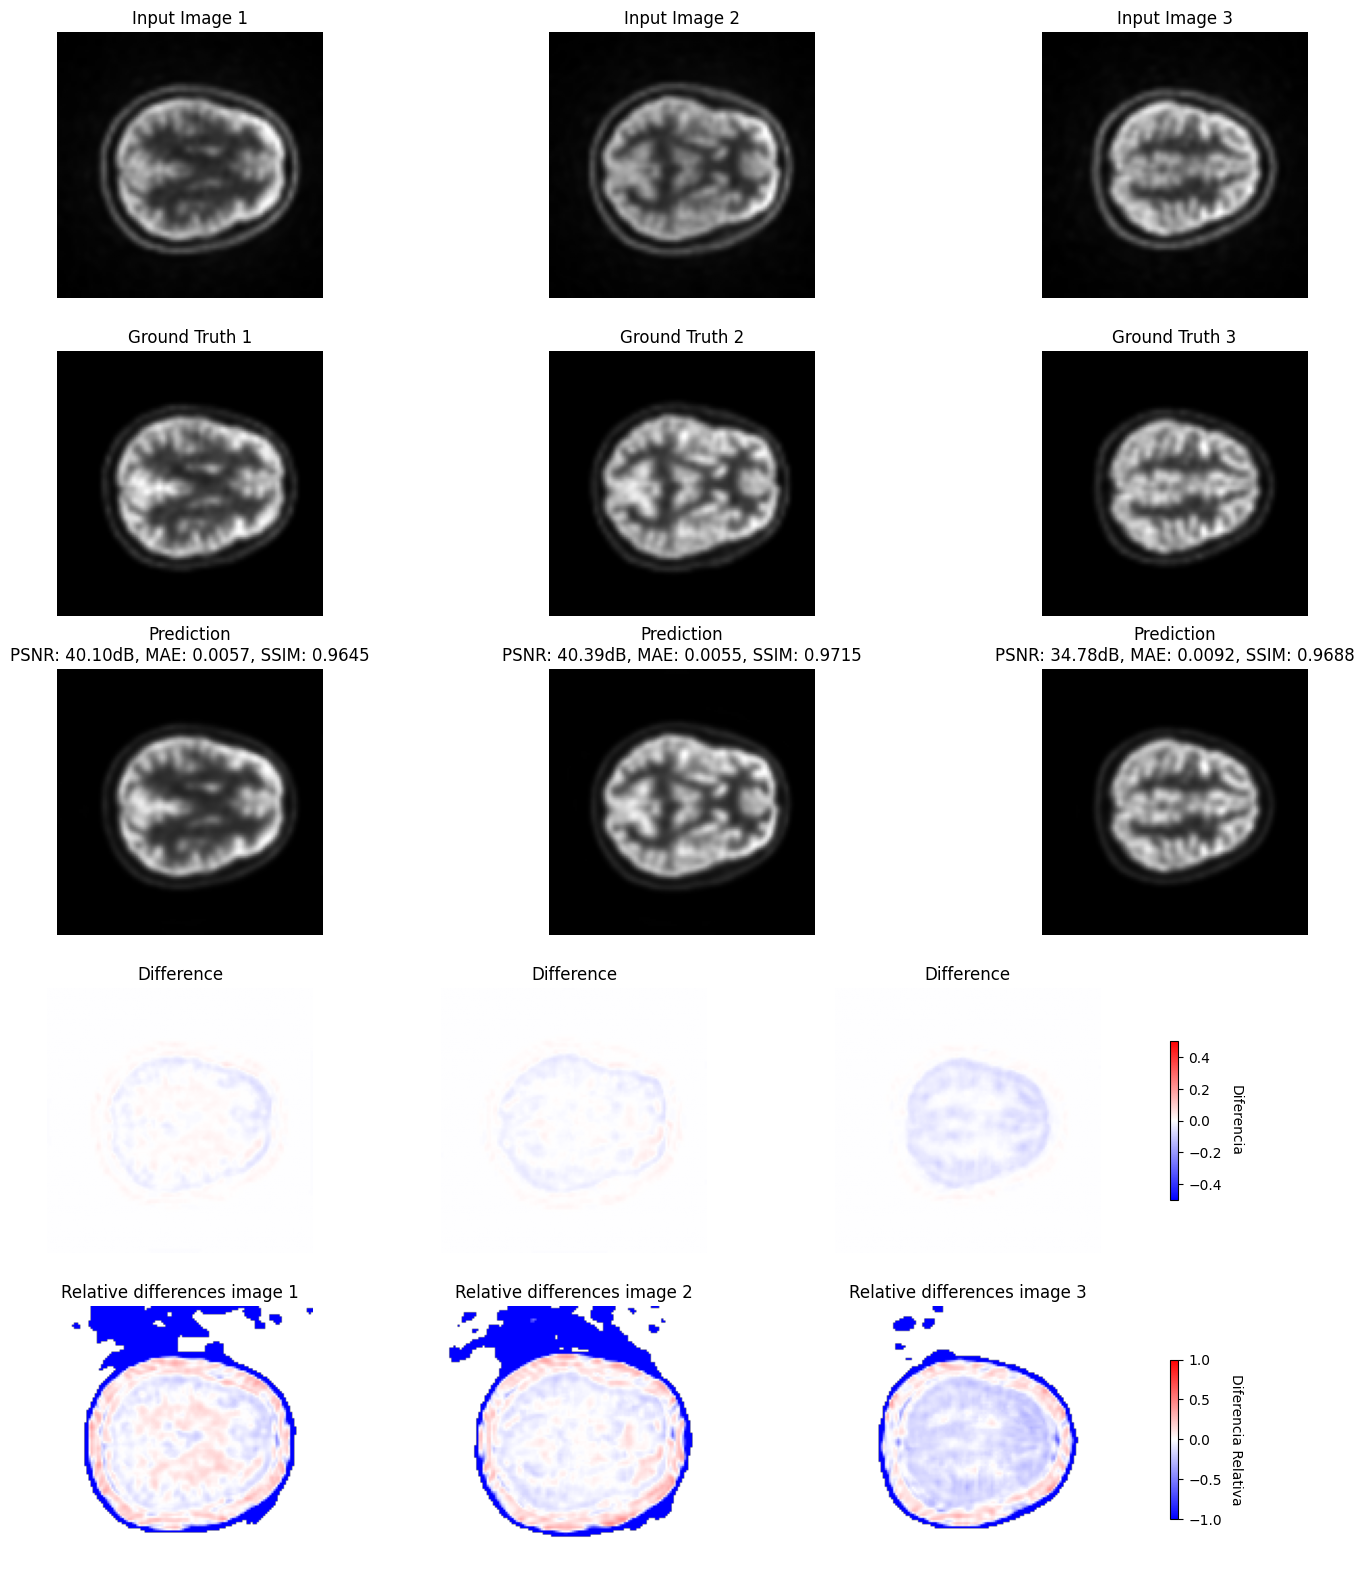

In [9]:
evaluator.visualize_predictions(model, test_loader)

# 3 - Test attention Unet

In [10]:
model_name = 'attention1'
model_config = load_config(os.path.join('..', 'models', model_name, 'config', 'model_config.json'))
evaluator = ModelEvaluator(model_config=model_config)
model = get_global_metrics(model_config, evaluator, test_loader)

Configuration from '../models/attention1/config/model_config.json' loaded successfully.
== Evaluation metrics ==
 - PSNR: 37.3577995300293
 - MAE: 0.006200000178068876
 - MSE: 0.00019999999494757503
 - SSIM: 0.9879


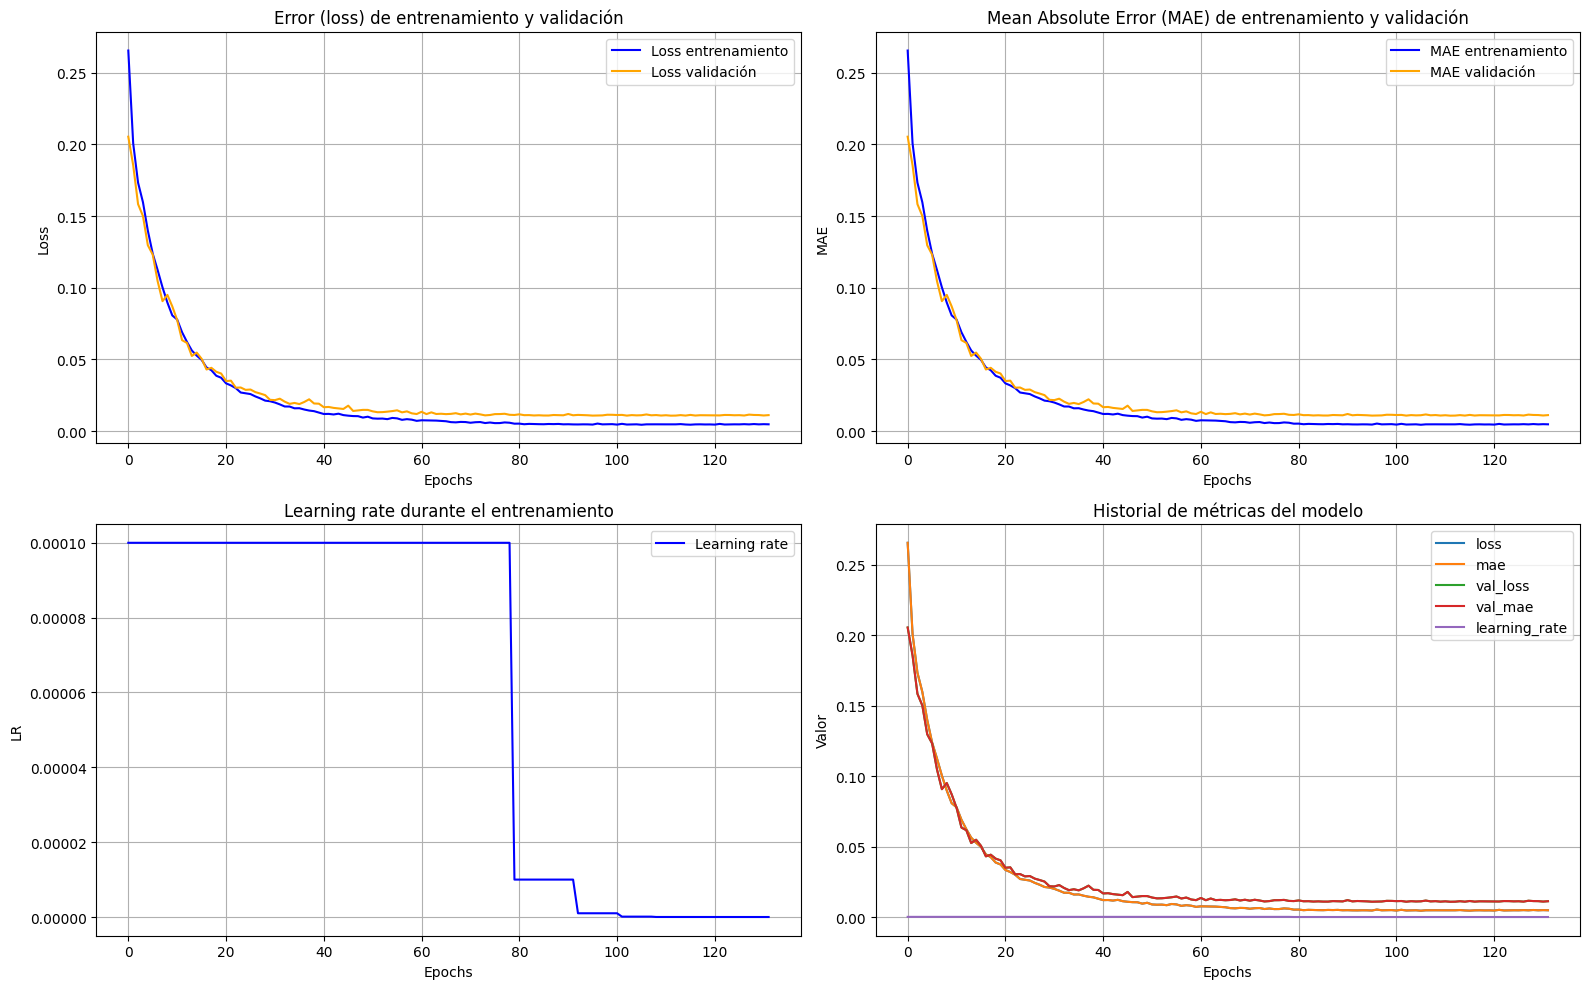

In [11]:
evaluator.plot_model_training_evolution()

torch.Size([8, 1, 8, 128, 128])
Input shape: torch.Size([8, 1, 8, 128, 128])
Target shape: torch.Size([8, 1, 8, 128, 128])
Prediction shape: torch.Size([8, 1, 8, 128, 128])
------------------------------------------------------------------------------------------------------------------------
73.73983
------------------------------------------------------------------------------------------------------------------------
-71.217186
------------------------------------------------------------------------------------------------------------------------
-40.9486


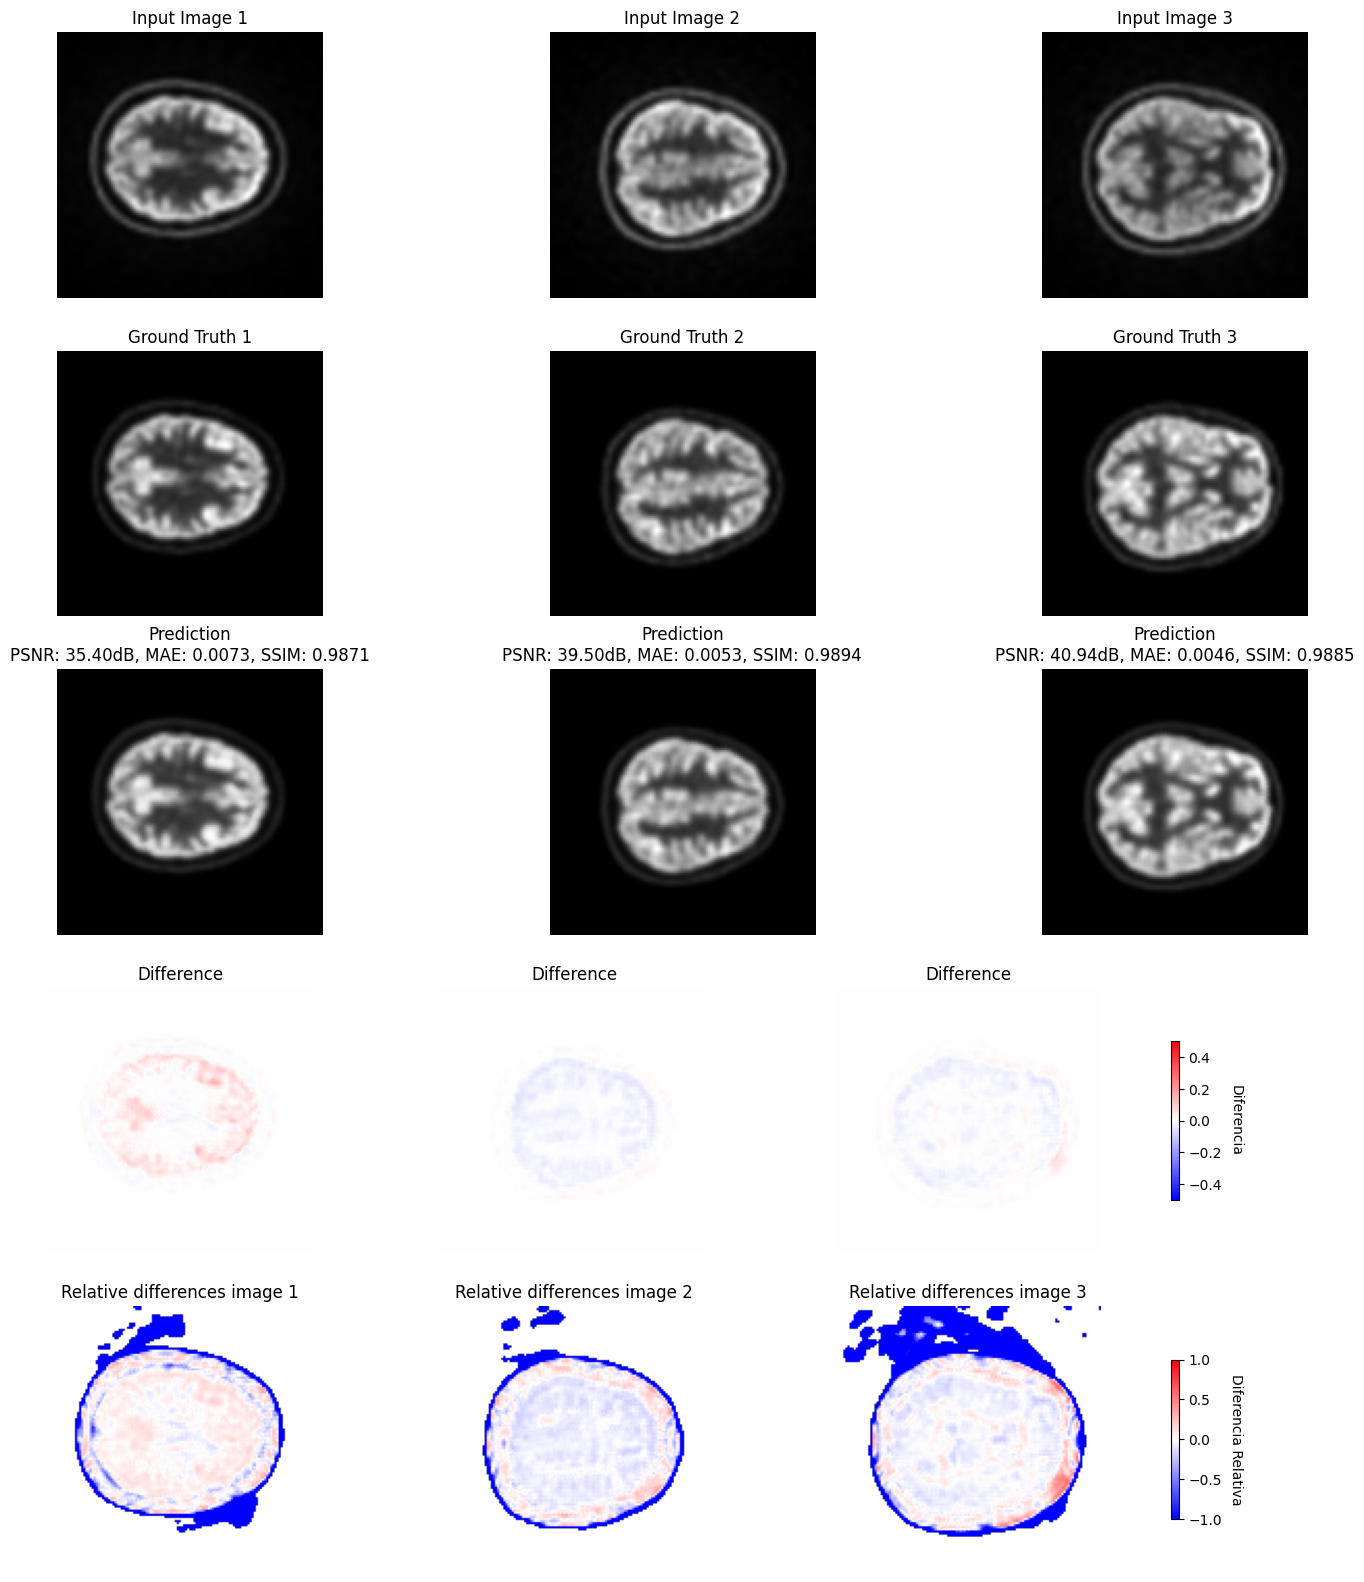

In [15]:
evaluator.visualize_predictions(model, test_loader)

# 4 - Test ViT

In [9]:
model_name = 'vit_pruebas_2'


model_config = load_config(os.path.join('..', 'models', model_name, 'config', 'model_config.json'))

evaluator = ModelEvaluator(model_config=model_config)
model = get_global_metrics(model_config, evaluator, test_loader)
model.view_model_graph(browser_view=True)

Configuration from '../models/vit_pruebas_2/config/model_config.json' loaded successfully.
== Evaluation metrics ==
 - PSNR: 31.89389991760254
 - MAE: 0.012299999594688416
 - MSE: 0.0007999999797903001
 - SSIM: 0.9198


/usr/bin/xdg-open: 882: /home/promise/.vscode-server/cli/servers/Stable-17baf841131aa23349f217ca7c570c76ee87b957/server/bin/helpers/browser.sh: not found
/usr/bin/xdg-open: 882: /home/promise/.vscode-server/cli/servers/Stable-17baf841131aa23349f217ca7c570c76ee87b957/server/bin/helpers/browser.sh: not found
xdg-open: no method available for opening '/home/promise/jhernandez/3d-notebooks/3d/9jun25/9jun25/models/vit_pruebas_2/graph/vit_pruebas_2.pdf'


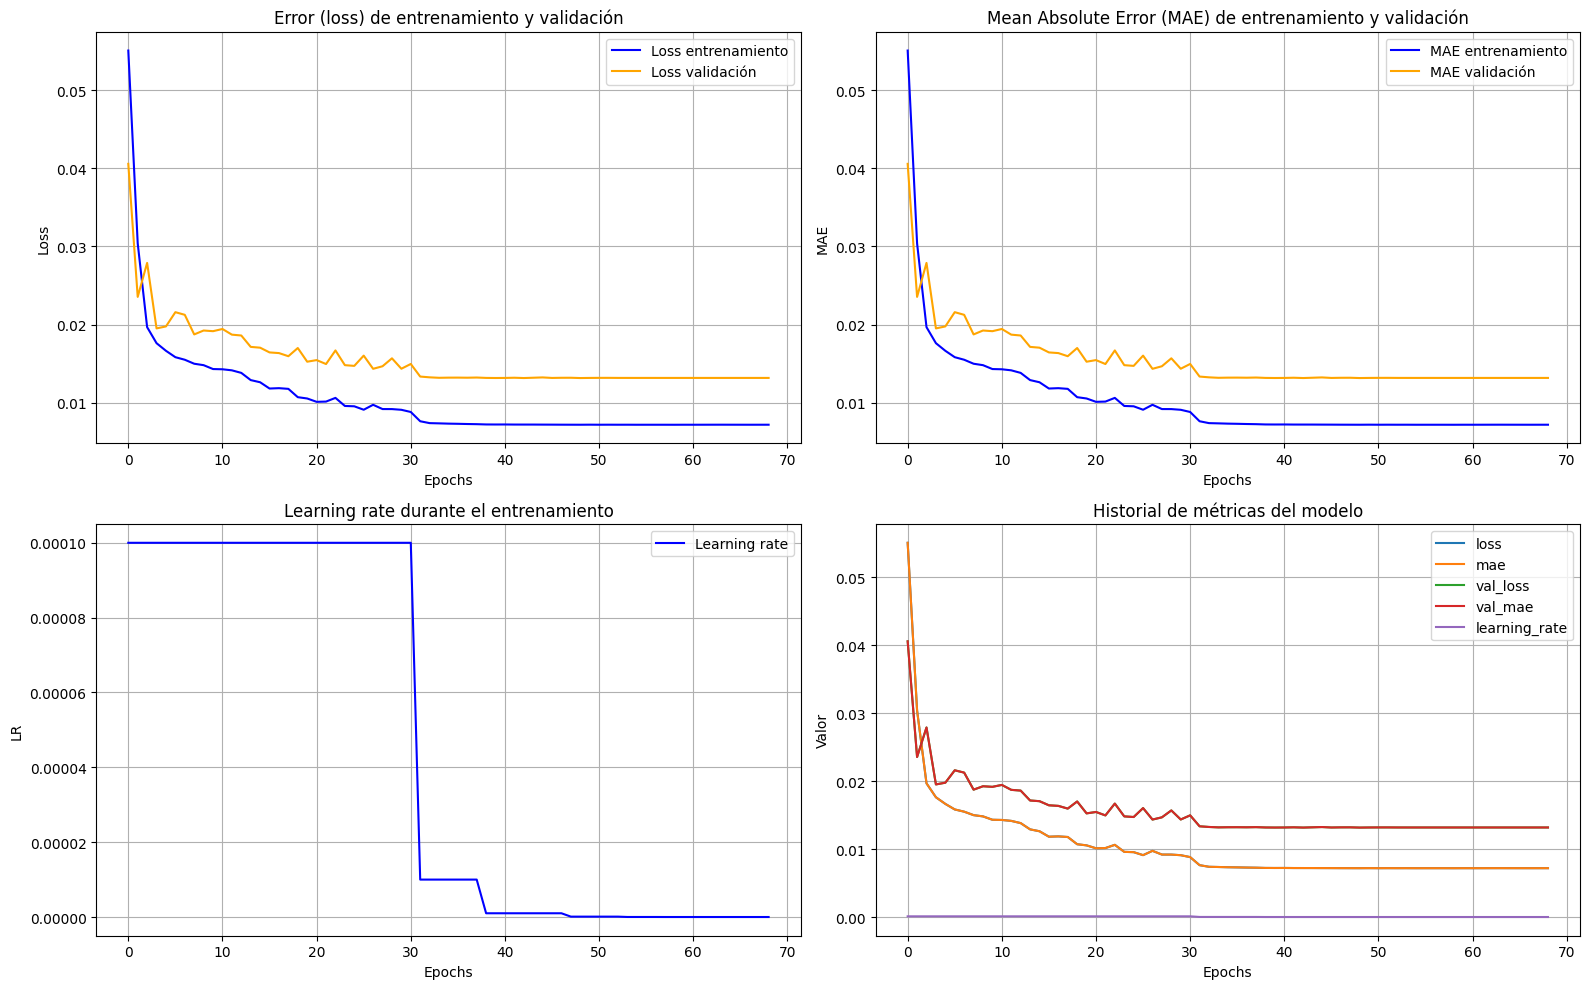

In [17]:
evaluator.plot_model_training_evolution()

torch.Size([8, 1, 8, 128, 128])
Input shape: torch.Size([8, 1, 8, 128, 128])
Target shape: torch.Size([8, 1, 8, 128, 128])
Prediction shape: torch.Size([8, 1, 8, 128, 128])
------------------------------------------------------------------------------------------------------------------------
-68.27138
------------------------------------------------------------------------------------------------------------------------
-80.0566
------------------------------------------------------------------------------------------------------------------------
65.46574


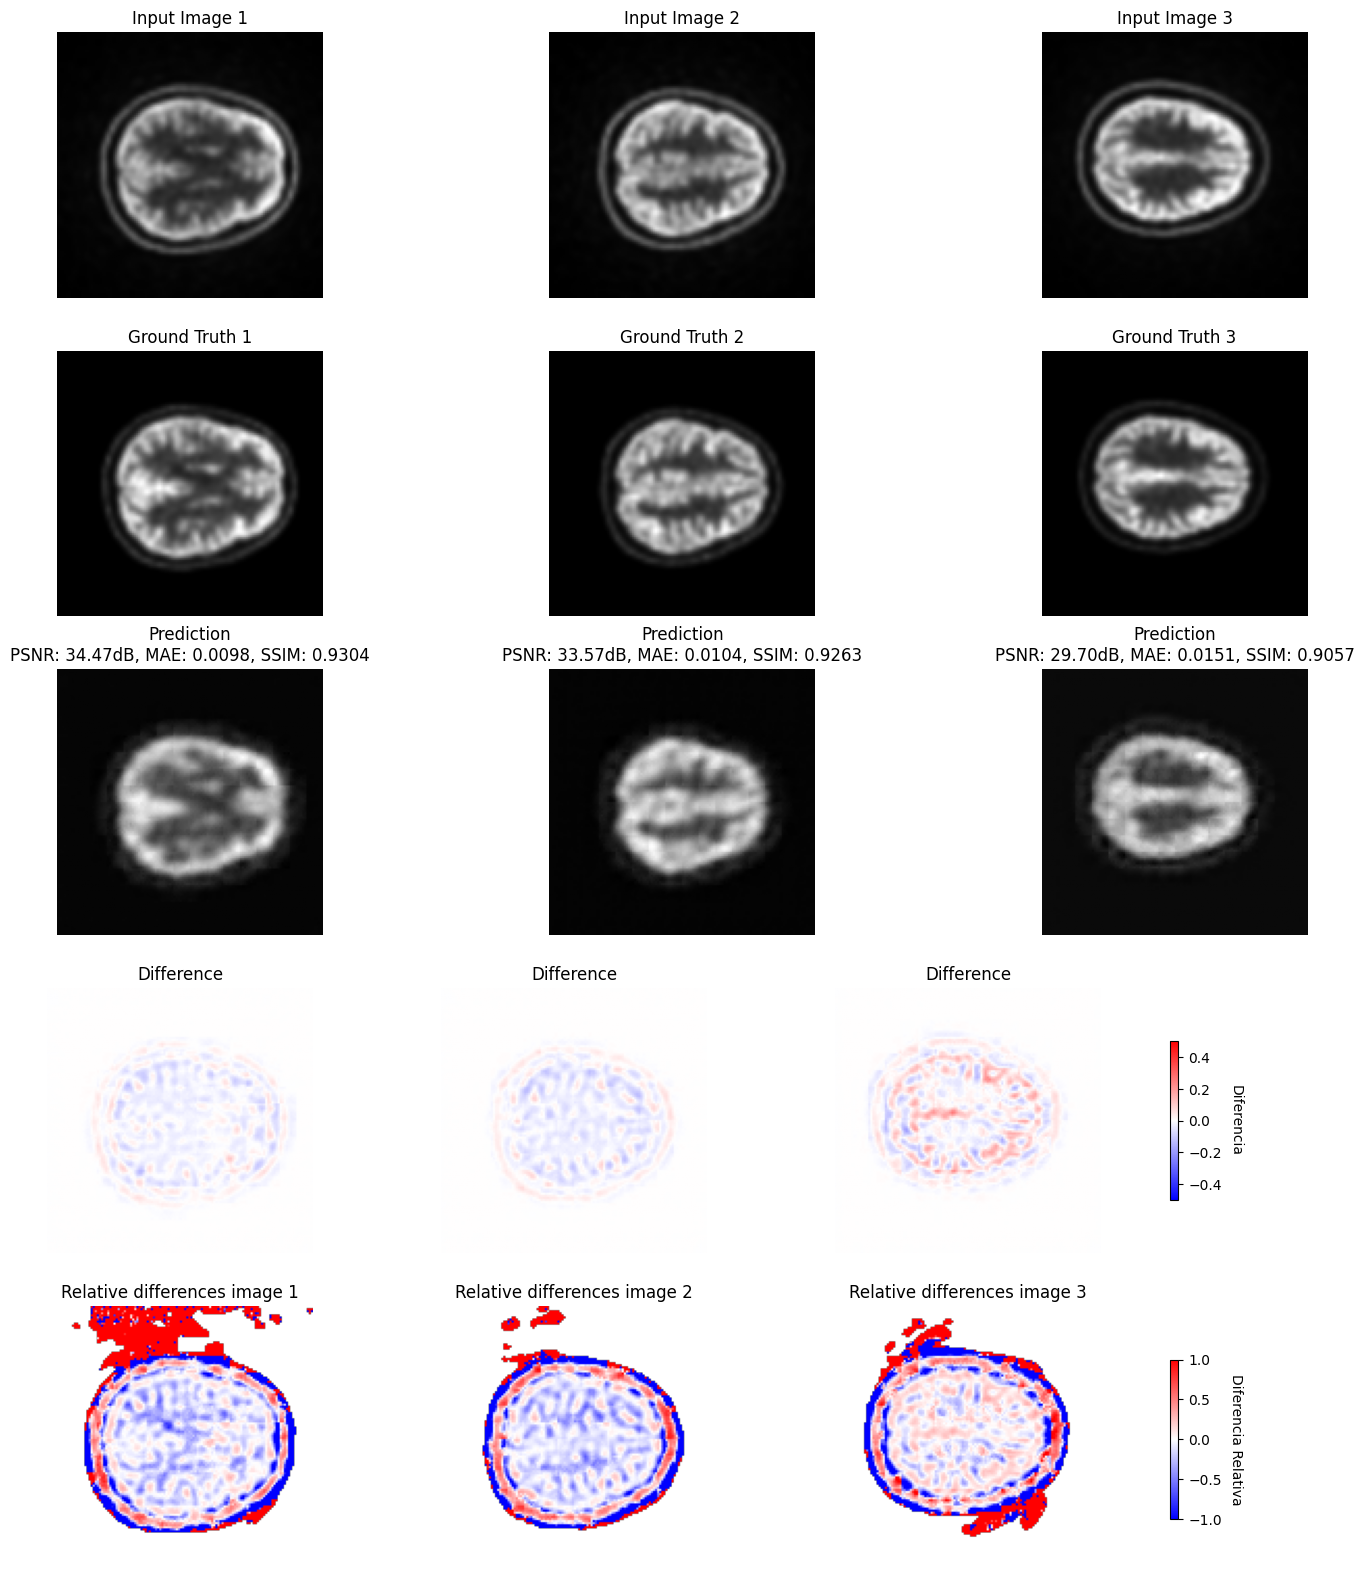

In [18]:
evaluator.visualize_predictions(model, test_loader)